# Equações Hipsométricas

> A seguir será apresentada a documentação e exemplo de uso da classe `EquacoesHipsometricas`

In [28]:
#| default_exp EquacoesHipsometricas

In [29]:
#| hide
from nbdev.showdoc import *

In [30]:
# | export
class EquacoesHipsometricas:

    def __tratativa_tabelas(dados, dap, ht, flag_treino, proporcao_treino):

        dados = dados.copy()

        if flag_treino is None:

            df_treino, df_teste = train_test_split(
                dados, test_size=1 - proporcao_treino, random_state=0
            )

        else:

            df_treino = dados[dados[flag_treino] == 1]
            df_teste = dados[dados[flag_treino] != 1]

        df_treino["treino"] = 1
        df_teste["treino"] = 0

        df_tratado = pd.concat([df_treino, df_teste], ignore_index=True)

        return df_tratado.rename(columns={dap: "dap", ht: "altura"})

    def __check_normalidade(dados_tratados):

        stat, p_value = shapiro(dados_tratados[dados_tratados["treino"] == 1]["altura"])

        stat = round(stat, 4)
        p_value = round(p_value, 4)
        if p_value < 0.05:  # Não segue uma distribuição normal

            print(
                f"A variável resposta não segue uma distribuição normal.\n Shapiro: {stat}. \n P-valor: {p_value}"
            )

        else:

            print(
                f"A variável resposta segue uma distribuição normal.\n Shapiro: {stat}. \n P-valor: {p_value}"
            )

    def __ajuste(x, y):
        x1 = sm.add_constant(x)
        model_x = sm.OLS(y, x1)
        fit_x = model_x.fit()
        return fit_x

    def __predict_model(model, x, name):

        if name in ["curtis", "stofells"]:

            return np.exp(model.predict(sm.add_constant(x)))

        return model.predict(sm.add_constant(x))

    def __equacoes(dados_tratado, parametros_iniciais):

        # modelos lineares
        dados_tratado["dap2"] = dados_tratado["dap"] ** 2
        dados_tratado["inverso_dap"] = 1 / dados_tratado["dap"]
        dados_tratado["log_dap"] = np.log(dados_tratado["dap"])
        dados_tratado["log_altura"] = np.log(dados_tratado["altura"])

        # separando dados de treino para o ajuste
        df_treino = dados_tratado[dados_tratado["treino"] == 1].copy()

        # funções para modelos não lineares
        def func_gomp(x, p1, p2, p3):
            return p1 * np.exp(-np.exp(p2 - p3 * x))

        def func_log(x, p1, p2, p3):
            return p1 / (1 + p2 * np.exp(-p3 * x))

        def func_champ(x, p1, p2, p3):
            return p1 * (1 - np.exp(-p2 * x)) ** p3

        modelos_n_lineares = ["gompertz", "logistico", "chapman_richards"]

        parametros_iniciais_default = {
            "gompertz": (24.0, 0.1, 0.1),
            "logistico": (24.0, 1, 0.1),
            "chapman_richards": (24.0, 0.1, 1.0),
        }

        if parametros_iniciais is None:

            parametros_iniciais = parametros_iniciais_default

        else:

            for modelo_i in parametros_iniciais_default.keys():

                parametros_iniciais[modelo_i] = parametros_iniciais.get(
                    modelo_i, parametros_iniciais_default[modelo_i]
                )

        for modelo_i in parametros_iniciais.keys():

            if isinstance(parametros_iniciais[modelo_i], tuple) == False:

                raise SyntaxError(
                    f"Formato dos parametros iniciais para o modelo {modelo_i} deve ser uma tuple."
                )

            else:

                if len(parametros_iniciais[modelo_i]) != 3:

                    raise SyntaxError(
                        f"O número de parametros iniciais para o modelo {modelo_i} deve ser 3. Exemplo: (10, 1, 1)."
                    )

        modelos = {
            "reta": {"x": df_treino[["dap"]], "y": df_treino["altura"]},
            "parabola": {"x": df_treino[["dap", "dap2"]], "y": df_treino["altura"]},
            "curtis": {"x": df_treino[["inverso_dap"]], "y": df_treino["log_altura"]},
            "stofells": {"x": df_treino[["log_dap"]], "y": df_treino["log_altura"]},
            "hericksen": {"x": df_treino[["log_dap"]], "y": df_treino["altura"]},
            "gompertz": {
                "function": func_gomp,
                "x": df_treino["dap"],
                "y": df_treino["altura"],
                "p0": parametros_iniciais["gompertz"],
            },
            "logistico": {
                "function": func_log,
                "x": df_treino["dap"],
                "y": df_treino["altura"],
                "p0": parametros_iniciais["logistico"],
            },
            "chapman_richards": {
                "function": func_champ,
                "x": df_treino["dap"],
                "y": df_treino["altura"],
                "p0": parametros_iniciais["chapman_richards"],
            },
        }

        modelos_output = {}
        for name, items in modelos.items():

            if name in modelos_n_lineares:

                popt, _ = curve_fit(
                    items["function"], items["x"], items["y"], p0=items["p0"]
                )

                modelos_output[name] = {"model": np.nan, "params": popt}

                funcao_i = items["function"]
                dados_tratado[f"altura_{name}"] = funcao_i(dados_tratado["dap"], *popt)

            else:

                model_i = EquacoesHipsometricas._EquacoesHipsometricas__ajuste(
                    items["x"], items["y"]
                )
                modelos_output[name] = {
                    "model": model_i,
                    "params": list(model_i.params),
                }
                dados_tratado[f"altura_{name}"] = (
                    EquacoesHipsometricas._EquacoesHipsometricas__predict_model(
                        model_i, dados_tratado[items["x"].columns], name
                    )
                )

        # criando tabela com parametros
        columns = ["Parametros/modelos"] + list(modelos_output.keys())
        data = []

        # numero máximo de parametros
        max_params = max(len(model["params"]) for model in modelos_output.values())

        # preenchendo tabela linha a linha
        for i in range(max_params):
            row = [f"b{i}"]
            for model in modelos_output.values():
                row.append(model["params"][i] if i < len(model["params"]) else np.nan)
            data.append(row)

        # Create the DataFrame
        df_parametros = pd.DataFrame(data, columns=columns)

        return modelos_output, dados_tratado, df_parametros

    def __metricas_modelo(y_observado, y_estimado, n_parametros):

        # Converte para arrays do NumPy
        y_observado = np.array(y_observado)
        y_estimado = np.array(y_estimado)

        # Número de observações
        n = len(y_observado)

        # Resíduos
        residuos = y_observado - y_estimado

        # Soma dos quadrados
        ss_total = np.sum(
            (y_observado - np.mean(y_observado)) ** 2
        )  # Soma total dos quadrados
        ss_residual = np.sum(residuos**2)  # Soma dos quadrados dos resíduos

        # Métricas básicas
        rmse = np.sqrt(ss_residual / n)  # Root Mean Square Error
        mae = np.mean(np.abs(residuos))  # Mean Absolute Error
        r2 = 1 - (ss_residual / ss_total)  # Coeficiente de determinação (R²)

        # R² ajustado
        r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - n_parametros - 1))

        # Log-Likelihood
        mse = ss_residual / n
        log_likelihood = -n / 2 * (np.log(2 * np.pi * mse) + 1)

        # AIC (Akaike Information Criterion)
        aic = 2 * n_parametros - 2 * log_likelihood

        # BIC (Bayesian Information Criterion)
        bic = n_parametros * np.log(n) - 2 * log_likelihood

        # Retorna os resultados
        return pd.DataFrame(
            {
                "Metrica": ["RMSE", "MAE", "R²", "R² Ajustado", "AIC", "BIC"],
                "Valor": [rmse, mae, r2, r2_ajustado, aic, bic],
            }
        )

    def __avaliar_modelo(output_modelos):

        modelos_output, dados_tratado, df_parametros = output_modelos

        df_metricas = {}

        for modelo_i in modelos_output.keys():

            numero_params = sum([~np.isnan(x) for x in df_parametros[modelo_i].values])

            for conjunto in [0, 1]:

                dados_i = dados_tratado[dados_tratado["treino"] == conjunto].copy()

                estatisticas = (
                    EquacoesHipsometricas._EquacoesHipsometricas__metricas_modelo(
                        dados_i["altura"], dados_i[f"altura_{modelo_i}"], numero_params
                    )
                )
                estatisticas.rename(columns={"Valor": modelo_i}, inplace=True)

                if df_metricas.get(conjunto) is None:

                    df_metricas[conjunto] = estatisticas

                else:

                    df_metricas[conjunto] = df_metricas[conjunto].merge(
                        estatisticas, on="Metrica", how="inner"
                    )

        return {"teste": df_metricas[0], "treino": df_metricas[1]}

    def __plotar_residuos(
        observed,
        residuals,
        model_name,
        x_label="Altura (m)",
        y_label="Resíduo (%)",
        x_lim=(0, 30),
        y_lim=(-30, 30),
        save_fig=False,
    ):

        plt.rcParams["figure.figsize"] = (7, 4)
        fig, ax = plt.subplots()
        ax.scatter(observed, residuals, c="black", label="Resíduos")
        ax.axhline(y=0.0, xmin=0.0, xmax=1, color="black", linestyle="--")
        plt.xlim(*x_lim)
        plt.ylim(*y_lim)
        plt.title(f"Resíduos - {model_name}")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        if save_fig:
            plt.savefig(f"{model_name}_residuos.png", dpi=300, bbox_inches="tight")
        plt.show()

    def __plotar_tendencia(formula, modelo, dap, altura):
        np.seterr(divide="ignore")
        x_range = range(0, 50)
        fig, ax = plt.subplots()
        ax.scatter(dap, altura, c="Green", label="Alturas observadas")
        plt.xlim(0, 30)
        plt.ylim(0, 30)
        x = np.array(x_range)
        y = eval(formula)  # Avalia a fórmula passada
        plt.title(f"{modelo}")
        plt.xlabel("DAP (cm)")
        plt.ylabel("Altura (m)")
        plt.plot(x, y, c="black", label="Predição do modelo")
        ax.legend(loc="lower right")
        # plt.savefig(f'{modelo}_tendencia.png')

    def __separada_dados(dados, conjunto_dados):

        if conjunto_dados is None:

            df = dados

        elif conjunto_dados == "treino":

            df = dados[dados["treino"] == 1]

        elif conjunto_dados == "teste":

            df = dados[dados["treino"] == 0]

        else:

            raise SyntaxError(
                f"O conjunto de dados deve ser 'treino' ou 'teste', parametro informado: '{conjunto_dados}'"
            )

        return df

    def __init__(
        self,
        dados,  # tabela com as informações das árvores
        dap: str,  # nome da coluna com o diamêtro a altura do peito em cm
        ht: str = None,  # nome da coluna com o diamêtro a altura do peito em m
        flag_treino: str = None,  # flag com a identificação dos dados de treino, esse valor deve ser 1.
        proporcao_treino: float = 0.7,  # proporção dos dados de treino caso não seja informado um flag de treino.
        parametros_iniciais: dict = None,  # parametros iniciais para os modelos não lineares.
    ):

        tabela_tratada = (
            EquacoesHipsometricas._EquacoesHipsometricas__tratativa_tabelas(
                dados, dap, ht, flag_treino, proporcao_treino
            )
        )

        output_modelos = EquacoesHipsometricas._EquacoesHipsometricas__equacoes(
            tabela_tratada, parametros_iniciais
        )

        self.__output_modelos, self.__dados_tratados, self.tabela_parametros = (
            output_modelos
        )

        remove_list = ["dap2", "inverso_dap", "log_dap", "log_altura"]
        self.tabela_predicoes = self.__dados_tratados[
            [x for x in self.__dados_tratados.columns if x not in remove_list]
        ]

        EquacoesHipsometricas._EquacoesHipsometricas__check_normalidade(
            self.__dados_tratados
        )

        self.tabela_metricas = EquacoesHipsometricas._EquacoesHipsometricas__avaliar_modelo(
            output_modelos
        )

    def grafico_residuos(self, lista_modelos=None, conjunto_dados=None):

        # separando conjunto de dados
        df = EquacoesHipsometricas._EquacoesHipsometricas__separada_dados(
            self.__dados_tratados, conjunto_dados
        )

        # verificando quais modelos plotar
        lista_modelos = (
            self.__output_modelos.keys() if lista_modelos is None else lista_modelos
        )

        for modelo_i in lista_modelos:

            residuo_i = (df["altura"] - df[f"altura_{modelo_i}"]) / df["altura"] * 100

            arrendondamento = lambda value: ((value + 4) // 5) * 5

            x_lim = arrendondamento(np.max(df["altura"]) + 1)
            y_lim = arrendondamento(np.max(residuo_i) + 1)
            EquacoesHipsometricas._EquacoesHipsometricas__plotar_residuos(
                df["altura"],
                residuo_i,
                modelo_i,
                "Altura (m)",
                "Resíduo (%)",
                x_lim=(0, x_lim),
                y_lim=(-y_lim, y_lim),
            )

    def grafico_tendencia(self, lista_modelos=None, conjunto_dados=None):

        # separando conjunto de dados
        df = EquacoesHipsometricas._EquacoesHipsometricas__separada_dados(
            self.__dados_tratados, conjunto_dados
        )

        # Dicionário de modelos e fórmulas
        modelos = {
            "reta": {"formula": "{0} + x * {1}"},
            "parabola": {"formula": "{0} + x * {1} + (x ** 2) * {2}"},
            "curtis": {"formula": "np.exp({0} + {1} / x)"},
            "stofells": {"formula": "np.exp({0} + {1} * np.log(x))"},
            "hericksen": {"formula": "{0} + {1} * np.log(x)"},
            "logistico": {"formula": "{0} / (1 + {1} * np.exp(-{2} * x))"},
            "gompertz": {"formula": "{0} * np.exp(-np.exp({1} - {2} * x))"},
            "chapman_richards": {"formula": "{0} * (1 - np.exp(-{1} * x)) ** {2}"},
        }

        # verificando quais modelos plotar
        lista_modelos = (
            self.__output_modelos.keys() if lista_modelos is None else lista_modelos
        )

        # Plotando e salvando os gráficos para todos os modelos
        for modelo, info in modelos.items():
            
            if modelo in lista_modelos:
                formula = info["formula"].format(*self.__output_modelos[modelo]["params"])
                EquacoesHipsometricas._EquacoesHipsometricas__plotar_tendencia(
                    formula, modelo, df["dap"], df["altura"]
                )

In [31]:
#| export
#from ForestScience.EquacoesHipsometricas import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import shapiro
import matplotlib.pyplot as plt

In [32]:
#| hide
import nbdev; nbdev.nbdev_export()

**Atributos**

**tabela_parametros**: retorna uma tabela (dataframe pandas) com os parâmetros dos modelos ajustados 

**tabela_predicoes**: retorna uma tabela (dataframe pandas) com as predições utilizando os modelos ajustados

**tabela_metricas**: retorna um dicionário (dict) com dois dataframes (dataframe pandas) ['treino', 'teste'] as métricas de treino e teste, respectivamente

**Metódos**

**grafico_residuos**(): plota os gráficos de resíduos.

**grafico_tendencia**(): plota os gráficos de tendencia.

### Exemplo de uso

<br>
Importe os pacotes necessários: <br>
```sh
from ForestScience.EquacoesHipsometricas import *
import pandas as pd
```


In [33]:
# leitura dos dados
dados = pd.read_csv('tabela_teste_equacoes_hipsometricas.csv')
dados.head()

,arvore,dap,altura
0,1,14.5,21.2
1,2,11.2,19.0
2,3,14.1,18.5
3,4,13.6,19.7
4,5,8.1,12.4


In [34]:
# Inicializa a classe EquacoesHipsometricas para realizar o ajuste das equações
# Obs.: pode ser informado os parâmetros iniciais para ajuste das equações não lineares, nesse caso apenas de gompertez foi informado
hip = EquacoesHipsometricas(dados, 'dap', 'altura', proporcao_treino=0.8, parametros_iniciais={'gompertz': (24, 0.1, 0.1)})

A variável resposta segue uma distribuição normal.
 Shapiro: 0.958. 
 P-valor: 0.5342


In [35]:
# exibindo a tabela com as predições
hip.tabela_predicoes

,arvore,dap,altura,treino,altura_reta,altura_parabola,altura_curtis,altura_stofells,altura_hericksen,altura_gompertz,altura_logistico,altura_chapman_richards
0,2,11.2,19.0,1,17.734566,17.883061,18.161976,17.754548,18.048186,17.905727,17.869192,17.932612
1,14,19.2,25.5,1,24.319078,23.942069,23.466664,24.195987,23.778009,23.868625,23.873826,23.919044
2,24,14.0,20.1,1,20.039145,20.306344,20.539102,20.182034,20.420322,20.350430,20.335097,20.324355
3,17,19.0,23.1,1,24.154465,23.823018,23.378213,24.050918,23.666693,23.756717,23.764429,23.797563
4,9,11.5,17.6,1,17.981485,18.158287,18.455708,18.026129,18.329186,18.185827,18.148581,18.207512
5,7,11.2,18.6,1,17.734566,17.883061,18.161976,17.754548,18.048186,17.905727,17.869192,17.932612
6,18,19.2,24.5,1,24.319078,23.942069,23.466664,24.195987,23.778009,23.868625,23.873826,23.919044
7,5,8.1,12.4,1,15.183067,14.819981,14.353003,14.739638,14.603363,14.785133,14.845221,14.774941
8,3,14.1,18.5,1,20.121451,20.386862,20.610896,20.264698,20.495984,20.430563,20.416607,20.403082
9,6,7.9,13.4,1,15.018455,14.608645,14.047308,14.529515,14.337586,14.571490,14.645087,14.548575


In [36]:
# exibindo a tabela com os parametros
hip.tabela_parametros

,Parametros/modelos,reta,parabola,curtis,stofells,hericksen,gompertz,logistico,chapman_richards
0,b0,8.516249,4.930828,3.514332,1.489185,-7.634277,29.992188,28.460197,37.828207
1,b1,0.823064,1.389242,-6.888018,0.574299,10.630538,0.478680,2.869667,0.039552
2,b2,NaN,-0.020785,NaN,NaN,NaN,0.101847,0.140828,0.726420


In [37]:
# exibindo a tabela com as métricas de treino
hip.tabela_metricas['treino']

,Metrica,reta,parabola,curtis,stofells,hericksen,gompertz,logistico,chapman_richards
0,RMSE,1.222528,1.193900,1.201695,1.193533,1.177582,1.196448,1.205764,1.184035
1,MAE,1.022917,1.022952,0.983278,1.016212,0.996932,1.025276,1.034680,1.011993
2,R²,0.854911,0.861627,0.859814,0.861712,0.865383,0.861036,0.858863,0.863904
3,R² Ajustado,0.836775,0.833952,0.842291,0.844426,0.848556,0.833243,0.830636,0.836685
4,AIC,65.554647,66.654234,64.901530,64.642554,64.131271,66.735240,67.029973,66.338931
5,BIC,67.443525,69.487551,66.790408,66.531432,66.020149,69.568557,69.863290,69.172248


In [38]:
# exibindo a tabela com as métricas de teste
hip.tabela_metricas['teste']

,Metrica,reta,parabola,curtis,stofells,hericksen,gompertz,logistico,chapman_richards
0,RMSE,1.605355,1.513757,1.491186,1.575678,1.487316,1.500690,1.505616,1.504469
1,MAE,1.344607,1.379121,1.441646,1.418328,1.411046,1.379351,1.369166,1.384048
2,R²,0.780958,0.805241,0.811005,0.788981,0.811985,0.808589,0.807330,0.807623
3,R² Ajustado,0.561915,0.220963,0.622011,0.577963,0.623970,0.234355,0.229320,0.230493
4,AIC,22.922836,24.335329,22.185102,22.736239,22.159116,24.248633,24.281406,24.273785
5,BIC,22.141712,23.163642,21.403978,21.955115,21.377992,23.076946,23.109719,23.102099


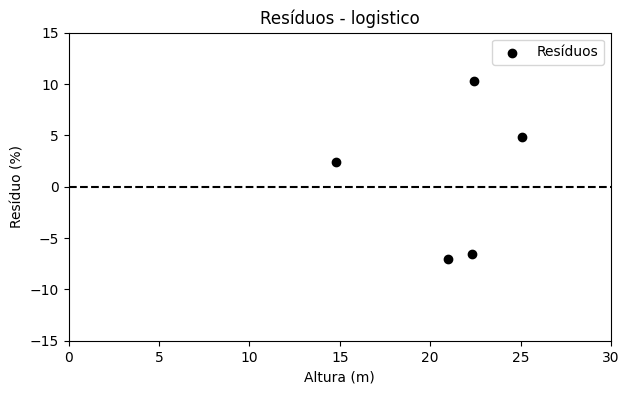

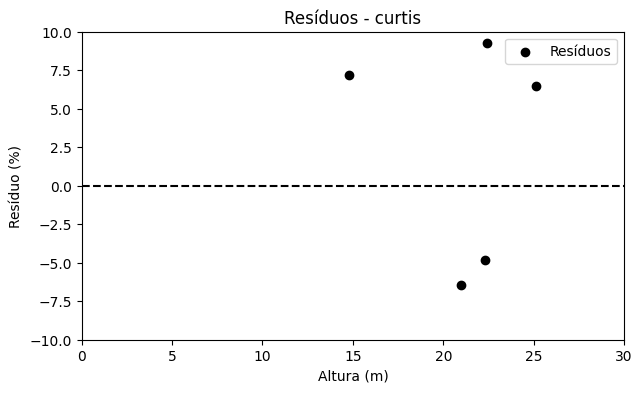

In [39]:
# exibindo o gráfico de resíduos para os dados de teste para o modelo de gompertz
hip.grafico_residuos(['logistico', 'curtis'], 'teste')

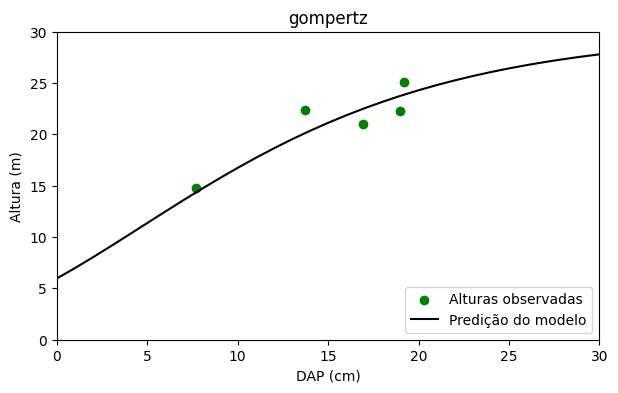

In [40]:
# exibindo o gráfico de tendência para os dados de teste para todos os modelos
hip.grafico_tendencia(lista_modelos= ['gompertz'], conjunto_dados = 'teste')